# Task 3 Classification 

#### Group: B (Joseph Weibel / Rebecka Fahrni)

In [105]:
from datasets import load_dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from skmultilearn.model_selection import IterativeStratification
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
import os


In [106]:
data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

# add label and text length
df['labels'] = df.prediction.apply(lambda x: x[0]['label'])
df = df.set_index('text')
df.shape


(4966, 13)

In [107]:
df_ohe = pd.get_dummies(df['labels'])
df_ohe = df_ohe.groupby(df_ohe.index).sum()
df_ohe.shape

(2357, 40)

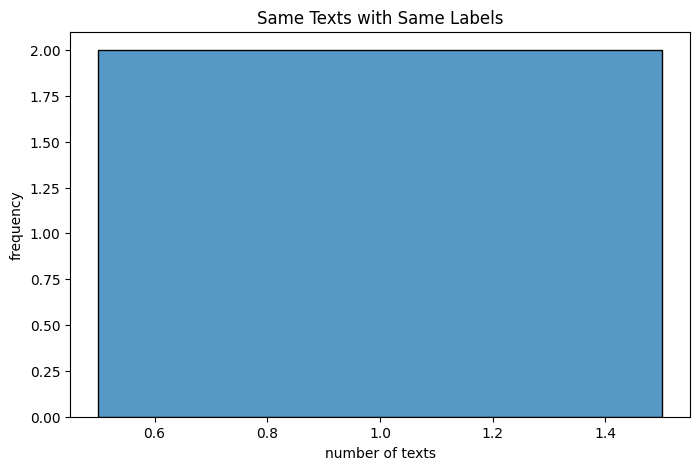

In [108]:
df_duplicate_labels = (df_ohe > 1).sum(axis=1)
df_duplicate_labels = df_duplicate_labels[df_duplicate_labels > 0]
plt.figure(figsize=(8, 5))
sns.histplot(df_duplicate_labels)
plt.title('Same Texts with Same Labels')
plt.xlabel('number of texts')
plt.ylabel('frequency')
plt.show()

In [109]:
df_ohe = df_ohe.clip(upper=1)

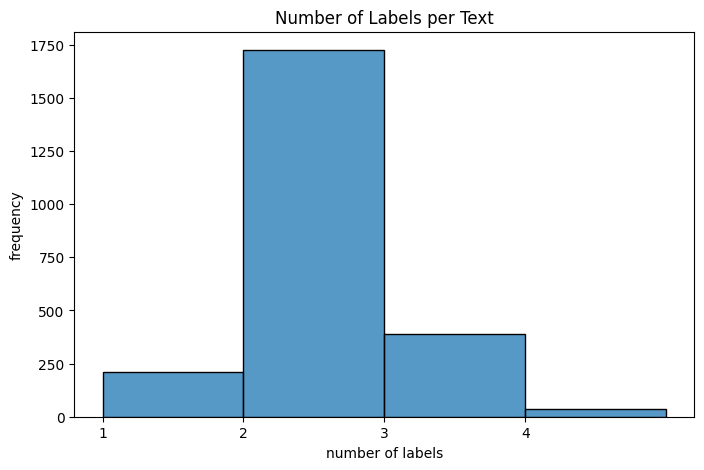

In [110]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ohe.sum(axis=1), binwidth=1)
plt.title('Number of Labels per Text')
plt.xlabel('number of labels')
plt.ylabel('frequency')
plt.xticks([1, 2, 3, 4])
plt.show()

In [125]:
df_ohe = df_ohe.drop(columns=df_ohe.columns[df_ohe.sum(axis=0) < 25])
df_ohe.shape

(2357, 26)

## Evaluation

In [126]:
n_splits = 5

if not os.path.exists('./data/fold_0_train.csv'):
	k_fold = IterativeStratification(n_splits=n_splits, order=1)
	for idx, (train_idx, test_idx) in enumerate(k_fold.split(df_ohe.index, df_ohe.values)):
		train, test = df_ohe.iloc[train_idx], df_ohe.iloc[test_idx]

		train.to_csv(f'./data/fold_{idx}_train.csv')
		test.to_csv(f'./data/fold_{idx}_test.csv')


In [128]:
splits = []
for idx in range(n_splits):
	train = pd.read_csv(f'./data/fold_{idx}_train.csv', index_col=0)
	test = pd.read_csv(f'./data/fold_{idx}_test.csv', index_col=0)
	splits.append((train.index, test.index, train.values, test.values))

print(len(splits))

5


## Baseline

In [48]:
# sw = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# texts = df_ohe.index.str.lower()
# texts = [word_tokenize(text) for text in texts]
# texts = [[lemmatizer.lemmatize(word) for word in text if word not in sw] for text in texts]
# texts = [[text for word in text if re.match('[a-z]', word)] for text in texts]
# texts

In [118]:
from sklearn.utils.class_weight import compute_sample_weight
# lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

# pipeline = Pipeline([
# 	['tfidf', TfidfVectorizer(
# 		min_df=3,
# 		max_df=0.95,
# 		lowercase=True,
# 		preprocessor=lemmatizer.lemmatize,
# 		stop_words=[lemmatizer.lemmatize(word) for word in stopwords.words('english')]
# 	)],
# 	['nb', MultiOutputClassifier(MultinomialNB())]
# ])

# cross_val_score(pipeline, df_ohe.index, df_ohe.values, cv=k_fold, n_jobs=-1, scoring='f1_macro')

# conf_matrix = np.zeros((df_ohe.shape[1], 2, 2))
f1_scores = np.zeros((n_splits, df_ohe.shape[1]))
for idx, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
	vectorizer = TfidfVectorizer(
		min_df=3,
		max_df=0.5,
		lowercase=True,
		preprocessor=stemmer.stem,
		stop_words=[stemmer.stem(word) for word in stopwords.words('english')]
	)
	X_train_transformed = vectorizer.fit_transform(X_train)
	X_test_transformed = vectorizer.transform(X_test)

	sample_weights = compute_sample_weight('balanced', Y_train)

	model = MultiOutputClassifier(MultinomialNB())
	# model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1))
	# model = MultiOutputClassifier(SVC(kernel='linear', probability=True))
	model.fit(X_train_transformed, Y_train)
	Y_pred = model.predict(X_test_transformed)



	# conf_matrix += multilabel_confusion_matrix(Y_test, Y_pred)

	# f1_scores = np.zeros(Y_test.shape[1])
	# for idx in range(Y_test.shape[1]):
	# 	f1_scores[idx] = f1_score(Y_test, Y_pred, pos_label=idx)

	# print(f1_scores.mean())
	# print(confusion_matrix(Y_test, Y_pred))
	# print(classification_report(Y_test, Y_pred))
	f1_scores[idx] = f1_score(Y_test, Y_pred, average=None)

# print(conf_matrix)

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score i

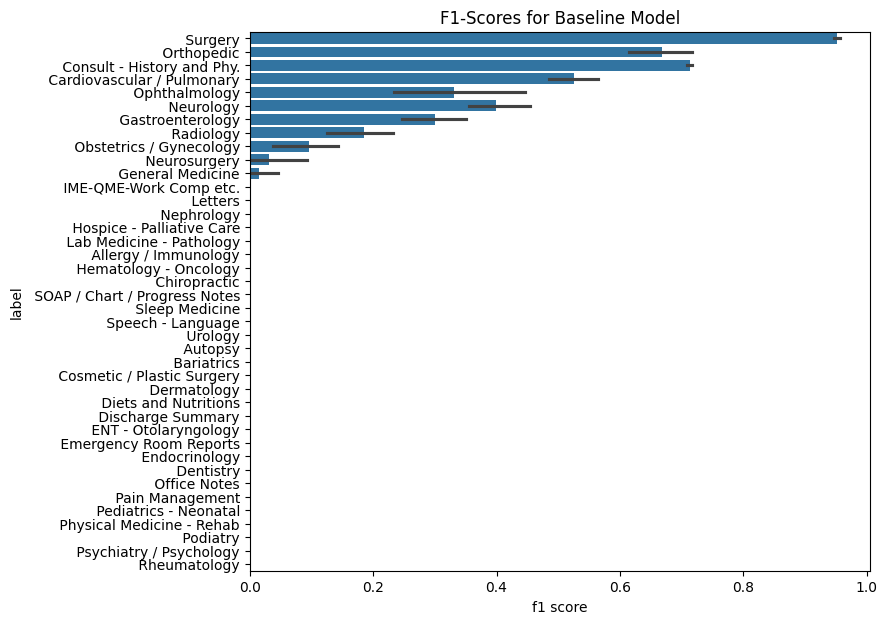

In [119]:
f1_scores_df = pd.DataFrame(f1_scores.T, index=df_ohe.columns)
f1_scores_df = f1_scores_df.melt(var_name='iteration', value_name='score', ignore_index=False)
f1_scores_df = f1_scores_df.reset_index(names='label')
f1_scores_df = f1_scores_df.sort_values(by='score', ascending=False)
plt.figure(figsize=(8, 7))
sns.barplot(f1_scores_df, x='score', y='label')
plt.title('F1-Scores for Baseline Model')
plt.xlabel('f1 score')
plt.ylabel('label')
plt.show()

## BERT

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.texts.items()}
        item['labels'] = self.labels[idx]
        return item

In [10]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def compute_metrics(eval_pred):
	Y_pred, Y_test = eval_pred
	Y_pred = Y_pred > 0.5
	# Y_pred = np.argmax(logits, axis=-1)

	return f1_score(Y_test, Y_pred, average=None)

def train_bert_models(model_name):
	tokenizer = BertTokenizer.from_pretrained(model_name)
	model = AutoModelForSequenceClassification.from_pretrained(
		model_name,
		num_labels=df_ohe.shape[1],
		problem_type='multi_label_classification'
	)
	model.to(device)
	for i, (train_idx, test_idx) in enumerate(k_fold.split(df_ohe.index, df_ohe.values)):
		X_train, X_test = df_ohe.index[train_idx], df_ohe.index[test_idx]
		Y_train, Y_test = df_ohe.astype('float32').values[train_idx], df_ohe.astype('float32').values[test_idx]
		X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=256)
		X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, max_length=256)

		training_args = TrainingArguments(
			output_dir=f'./models/{model_name}/it_{i}',
			num_train_epochs=1,
			do_train=True,
			per_device_train_batch_size=32,
			learning_rate=3e-05,
			weight_decay=0.1,
			push_to_hub=False,
			logging_steps=50,
			save_total_limit=1
		)

		trainer = Trainer(
			model=model,
			args=training_args,
			train_dataset=Dataset(X_train_tokens, Y_train),
			tokenizer=tokenizer,
			compute_metrics=compute_metrics
		)

		trainer.train()

		prediction = trainer.predict(Dataset(X_test_tokens, Y_test))
		print(prediction.metrics)

In [11]:
train_bert_models('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rebecka-fahrni16. Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [33:12<00:00, 39.85s/it]


{'loss': 0.475, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 1995.8452, 'train_samples_per_second': 0.788, 'train_steps_per_second': 0.025, 'train_loss': 0.47496280670166013, 'epoch': 1.0}


100%|██████████| 98/98 [04:25<00:00,  2.83s/it]c:\Users\rebec\miniconda3\envs\myGPU\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rebec\miniconda3\envs\myGPU\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 98/98 [04:56<00:00,  3.02s/it]


{'test_loss': 0.3826029896736145, 'test_f1_score_micro': 0.0, 'test_f1_score_macro': 0.0, 'test_precision_micro': 0.0, 'test_precision_macro': 0.0, 'test_recall_micro': 0.0, 'test_recall_macro': 0.0, 'test_hamming_loss': 0.05277423469387755, 'test_accuracy': 0.0, 'test_f1_score': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), 'test_runtime': 299.1619, 'test_samples_per_second': 2.621, 'test_steps_per_second': 0.328}


  8%|▊         | 4/50 [02:40<31:14, 40.75s/it]

: 

In [ ]:
train_bert_models('medicalai/ClinicalBERT')

In [ ]:
train_bert_models('dmis-lab/biobert-v1.1')

## GPT

Todo:
- Texte abschneiden (512 Tokens)
- Baseline mit TFIDF und NB/SVM
 - Preprocessing Pipeline: Snowball, lowercasing, lemmatization, Satzzeichen entfernen, Zahlen entfernen
- BERT
 - kein Preprocessing
 - bert-base-uncased, biobert, ...
- GPT
 - llama2, meditron
 - pro Label und alle Label gleichzeitig abfragen
- Evaluierung
 - 3-fach cross-validation 
 - f1-scores (pro Label und insgesamt)
- Preprocessing
 - alle Label mit weniger als 20 Texten entfernen
 - Oversampling